In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import glob

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

In [3]:
os.chdir('/home/mike/repos/agnfinder')
# sotiria, change this to repo loc

In [4]:
# scp -r -oProxyJump=mikewalmsley@aquila.star.bris.ac.uk mike@zeus.star.bris.ac.uk:/scratch/agnfinder/agnfinder/results/vanilla_nested /media/mike/beta/agnfinder_results/vanilla_nested

In [5]:
# save_dir = 'results/emulated_sampling/real'
save_dir = '/media/mike/beta/agnfinder_results/vanilla_nested'

galaxy_locs = glob.glob(save_dir + '/*samples.h5py')
assert galaxy_locs


# open one galaxy for params
with h5py.File(galaxy_locs[0], mode='r') as f:
    params = f['samples'].attrs['free_param_names']

galaxies = []
true_observations = len(galaxy_locs)
for n, galaxy_loc in enumerate(galaxy_locs):
    try:
        with h5py.File(galaxy_loc, mode='r') as f:
            galaxies.append({
                'samples': np.squeeze(f['samples'][::100]),
                'true_observations': np.squeeze(f['true_observations'][...]),
                'uncertainty': f['uncertainty'][...],
                'name': n,
                'sampled_photometry': f['sampled_photometry'][::100]
            })
    except OSError:
        pass
    
n_samples = galaxies[0]['samples'].shape[0]
# samples = np.stack(sample_list, axis=1)

In [6]:
wavelengths = np.array([ 3545.9515156 ,  4669.6375124 ,  6156.34362463,  7470.59215536,
        8917.58185532, 16397.13029184, 12513.8266968 , 21392.23213854,
       10205.12640526,  8801.6644194 , 33461.019081  , 45952.08900757])

In [12]:
def plot_galaxy(galaxy, ax, wavelengths):
    true_photometry = galaxy['true_observations']
    input_params = galaxy['samples']
    sample_photometry = galaxy['sampled_photometry']
    np.random.shuffle(sample_photometry)

    ax.errorbar(wavelengths, true_photometry, label=r'true observation $\pm 2\sigma$', marker='+', linestyle='', yerr=galaxy['uncertainty']*2)
    ax.set_yscale('log')
    ax.set_xscale('log')
    for trace in sample_photometry[:50]:
        ax.scatter(wavelengths, trace, color='r', marker='+', alpha=0.05)
    ax.legend()
    ax.set_title('{} {}'.format('passive', galaxy['name']))
    ax.set_ylabel('Maggies')
    ax.set_xlabel('Wavelength (A)')

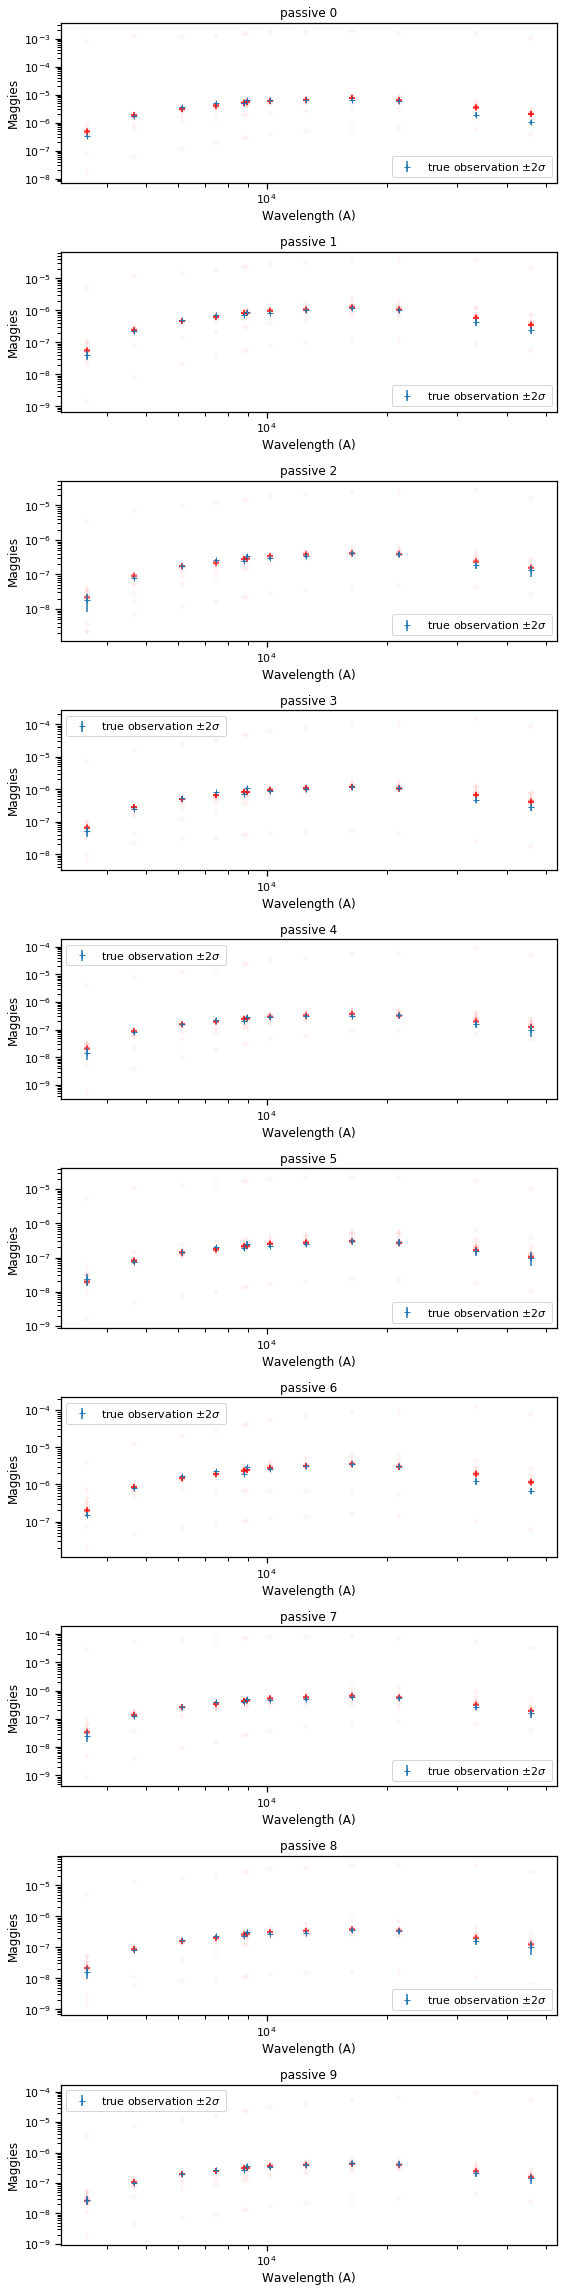

In [13]:
n_galaxies = 10

fig, axes = plt.subplots(nrows=n_galaxies, figsize=(8, 32))

n = 0
for galaxy in galaxies:
    ax = axes[n]
    plot_galaxy(galaxy, ax, wavelengths)
    n += 1
    if n >= n_galaxies:
        break
plt.tight_layout()